# 基于Armijo准则的最速下降法
吕之豪(1810064) 朱文臣(1710133)
## Armijo准则
给定$\rho\in(0,1/2)$，$\beta\in(0,1)$，$\tau>0$。找到最小的非负整数$m_k$满足：
$$f(x_k+\beta^{m_k}\tau d_k)\leq f(x_k) + \rho\beta^{m_k}\tau g_k^T d_k$$
取步长因子$\alpha_k=\beta^{m_k}\tau$。

## 实现
实现时令$step_0=-\tau g_k, res_0=-\rho g_k^T step_0$，然后两项同时乘$\beta$（即$step_i=\beta\cdot step_{i-1}, res_i=\beta\cdot res_{i-1}$），直至满足
$$f(x_k+step_i)\leq f(x_k) + res_i$$
此时$step_i$即为更新步长，$x_{k+1}=x_k+step_i$。

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['legend.fontsize'] = 10

class ArmijoSD:
    def __init__(
        self, f, x0: np.ndarray, df=None, 
        rho: float = 0.25, beta: float = 0.95, 
        tau: float = 1, eps: float = 1e-3
    ):
        assert tau > 0 and 0 < rho < 0.5 and 0 < beta < 1
        self.f = f
        self.df = df
        self.x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
        with torch.no_grad():
            fx0 = self.f(self.x)
            assert isinstance(fx0, torch.Tensor) and tuple(fx0.shape) == ()
            if self.df is not None:
                dfx0 = self.df(self.x)
                assert isinstance(dfx0, torch.Tensor)
                assert dfx0.shape == self.x.shape
        self.x_list = [self.x.tolist()]
        self.fx_list = [self.f(self.x).item()]
        self.rho = rho
        self.beta = beta
        self.tau = tau
        self.eps = eps
        from math import log10
        self.roundbits = int(-log10(self.eps))

    def __armijo(self) -> torch.tensor:
        if self.df is None:
            grad_x = torch.autograd.grad(self.f(self.x), self.x, retain_graph=False, create_graph=False)[0]
        else:
            grad_x = self.df(self.x)
        step = -self.tau * grad_x
        res = self.rho * grad_x.T @ step
        fk = self.f(self.x)
        while self.f(self.x + step) > fk + res:
            step *= self.beta
            res *= self.beta
        return step


    def optimize(self, max_iter: int = 100, verbose: int = 0):
        for it in range(max_iter):
            step = self.__armijo()
            with torch.no_grad():
                self.x += step
            self.x_list.append(self.x.tolist())
            self.fx_list.append(self.f(self.x).item())
            if verbose == 2:
                print(f'x{it+1}={[round(xi, self.roundbits) for xi in self.x_list[-1]]}, y{it+1}={round(self.fx_list[-1], self.roundbits)}')
            if torch.linalg.norm(step) < self.eps:
                break
        if verbose == 1:
            print(f'Final: x{it+1}={[round(xi, self.roundbits) for xi in self.x_list[-1]]}, y{it+1}={round(self.fx_list[-1], self.roundbits)}')


    def plot(self, figpath: str = 'plot.png', grid_size = 200j, func_name: str = None):
        assert tuple(self.x.shape) == (2,)
        xx = np.array([i[0] for i in self.x_list])
        yy = np.array([i[1] for i in self.x_list])
        surf_x, surf_y = np.mgrid[
            np.min(xx)-0.2:np.max(xx)+0.2:grid_size,
            np.min(yy)-0.2:np.max(yy)+0.2:grid_size
        ]
        surf_z = np.apply_along_axis(self.f, 2, np.stack((surf_x, surf_y), axis=2))
        beg = self.x_list[0]
        fig = plt.figure(figsize=(8,8))
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(surf_x, surf_y, surf_z, cmap='rainbow', label='ground truth', alpha=0.5)
        surf._facecolors2d = surf._facecolors3d
        surf._edgecolors2d = surf._edgecolors3d
        ax.plot(xx, yy, self.fx_list, 'go-', label='gradient descend', linewidth=5, markersize=8)
        ax.text(beg[0], beg[1], self.fx_list[0], 'x0=('+str(round(beg[0], self.roundbits))+','+str(round(beg[1], self.roundbits))+')')
        title = 'Steepest Descend(Armijo)\n' + \
                r'$\rho=' + str(self.rho) +\
                r', \beta=' + str(self.beta) +\
                r', \tau=' + str(self.tau) +\
                r', \epsilon=' + str(self.eps) + '$'
        if func_name is not None:
            title += '\n' + func_name
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('y')
        ax.legend()
        plt.savefig(figpath, bbox_inches='tight')
        plt.show()

## 测试函数求解
### Rosenbrock函数

x1=[1.139, 1.62], y1=10.471
x2=[1.307, 1.546], y2=2.759
x3=[1.227, 1.576], y3=0.553
x4=[1.263, 1.562], y4=0.173
x5=[1.246, 1.568], y5=0.085
x6=[1.254, 1.565], y6=0.068
x7=[1.25, 1.566], y7=0.064
x8=[1.251, 1.565], y8=0.063
x9=[1.251, 1.566], y9=0.063


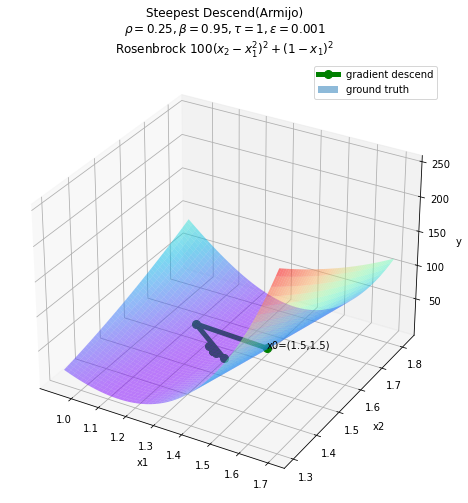

In [2]:
rosenbrock = lambda x: 100*(x[1]-x[0]**2)**2 + (1-x[0])**2
opt = ArmijoSD(rosenbrock, (1.5,1.5))
opt.optimize(verbose=2)
opt.plot(figpath='Rosenbrock.png', func_name='Rosenbrock $100(x_2-x_1^2)^2+(1-x_1)^2$')

### 广义Rosenbrock
$$f(x)=\sum_{i=1}^{n-1}[100(x_{i+1}-x_i^2)^2+(1-x_i)^2]$$
取n=5时

In [3]:
def general_rosenbrock(x):
    (100*(x[1:]-x[:-1]**2)**2+(1-x[:-1])**2).sum()
opt_gr = ArmijoSD(rosenbrock, (1.5, 2, 1.5, 1, 1.5), tau=3, rho=0.4, beta=0.9, eps=0.0001)
opt_gr.optimize(verbose=1, max_iter=1000)

Final: x1000=[1.3206, 1.7445, 1.5, 1.0, 1.5], y1000=0.1028


### Wood函数
$$f(x)=100(x_1^2-x_2)^2+(x_1-1)^2+(x_3-1)^2+90(x_3^2-x_4)^2+10.1[(x_2-1)^2+(x_4-1)^2]+19.8(x_2-1)(x_4-1)$$

In [4]:
def wood(x):
    x1 = x - 1
    return 100*(x[0]**2 - x[1])**2 + x1[0]**2 + x1[2]**2 + 90*(x[2]**2 - x[3])**2\
        + 10.1*(x1[1]**2 + x1[3]**2) + 19.8*x1[1]*x1[3]
opt_wood = ArmijoSD(wood, (1.3, 1.3, 1.3, 0.9), tau=2, eps=1e-4)
opt_wood.optimize(verbose=1, max_iter=1000)

Final: x1000=[1.0222, 1.0447, 0.9774, 0.9553], y1000=0.0018


### Powell奇异函数
$$f(x)=(x_1+10x_2)^2+5(x_3-x_4)^2+(x_2-2x_3)^4+10(x_1-x_4)^2$$

In [7]:
powell = lambda x: (x[0]+10*x[1])**2 + 5*(x[2]-x[3])**2 + (x[1]-2*x[2])**4 + 10*(x[0]-x[3])**2
opt_powell = ArmijoSD(powell, (2,1,0.5,0.8))
opt_powell.optimize(verbose=1, max_iter=1000)

Final: x254=[0.113, -0.011, 0.105, 0.111], y254=0.003


### 立方体函数
$$f(x)=100(x_2-x_1^3)^2+(1-x_1)^2$$

Final: x500=[0.94944, 0.85559], y500=0.00256


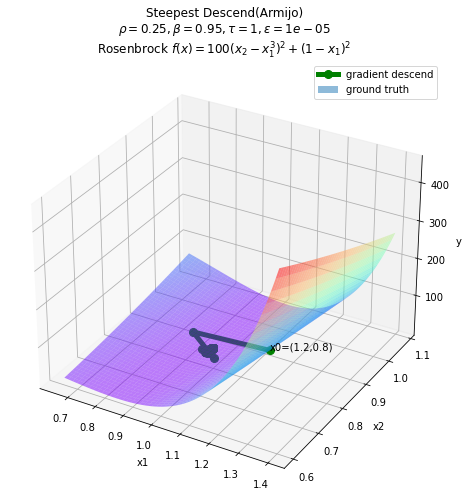

In [6]:
cube = lambda x: 100*(x[1]-x[0]**3)**2 + (1-x[0])**2
opt_cube = ArmijoSD(cube, (1.2, 0.8), eps=1e-5)
opt_cube.optimize(verbose=1, max_iter=500)
opt_cube.plot(figpath='cube.png', func_name=r'Rosenbrock $f(x)=100(x_2-x_1^3)^2+(1-x_1)^2$')

### 三角函数
$$f(x)=\sum_{i=1}^n[n+i(1-\cos x_i)-\sin x_i - \sum_{j=1}^n \cos x_j]^2$$
取$n=5$

In [13]:
def tri(x):
    cos_sum = x.cos().sum()
    i = torch.arange(len(x), dtype=torch.float, requires_grad=True) + 1
    return ((len(x) + i*(1-x.cos())-x.sin()-cos_sum)**2).sum()
opt_tri = ArmijoSD(tri, (2, 0.5,0.83, 1.2, 1.3), tau=2, eps=1e-4)
opt_tri.optimize(verbose=1, max_iter=1000)

Final: x126=[0.105, 0.112, 0.1217, 0.3522, 0.1938], y126=0.0


### 螺旋形凹谷函数
$$f(x)=100[(x_3-10\theta)^2-(\sqrt{x_1^2+x_2^2}-1)^2]+x_3^2$$
其中$\theta$满足
$$\begin{equation}
2\pi\theta=
\begin{cases}
arctan(\frac{x_1}{x_2})& x_1>0\\
\pi+arctan(\frac{x_2}{x_1})& x_1<0
\end{cases}
\end{equation}$$
$arctan(\frac{x_2}{x_1}) + \pi = 2\pi\theta, tan(2\pi\theta-\pi)=\frac{x_2}{x_1}, tan(2\pi\theta)=\frac{x_2}{x_1}, 2\pi\theta=arccot(\frac{x_1}{x_2})$

In [23]:
def spiral_concave_valley(x):
    from math import pi
    if x[0] > 0:
        theta = (x[0]/x[1]).arctan()
    else:
        theta = (x[1]/x[0]).arctan()+pi
    return 100*((x[2]-theta*5/pi)**2 + ((x[0]**2+x[1]**2).sqrt()-1)**2)+x[2]**2
opt_scv = ArmijoSD(spiral_concave_valley, (6, 9, 3), beta=0.1, eps=1e-4)
opt_scv.optimize(verbose=1, max_iter=2000)

Final: x494=[0.0321, 0.9995, 0.0509], y494=0.0026


## 其他函数
我们实现的最速下降类支持显式定义梯度和自动微分两种。

自动微分是基于pytorch的，所以只要是pytorch中支持的运算，都可以仅定义函数f，pytorch自动计算梯度，基本覆盖了所有基本代数运算。

对于较复杂的运算，如果pytorch没有函数直接支持，则可以显式定义梯度函数df。

事实上，分段的初等函数pytorch都能自动微分，只有广义函数或者像狄拉克函数那种奇异函数需要显示定义，但是这种函数优化问题里一般也不会遇到。

当然还有一种情况是遇到分母为零的无定义的间断点，需要我们恰当选取初值尽可能避免遇到这种简短的，实际上会出现两种结果，一种是由于浮点数误差实际是一个非常小的小数，对应很大的梯度；另一种情况是确实到0了，此时pytorch会返回Nan，此时程序最终结果也都会变成Nan（类似与训练神经网络时遇到的梯度爆炸），此时就一定要改初值、调参或者加边界条件了。

### 显式定义梯度的示例
书上的测试函数只要选用比较恰当的写法，都可以用pytorch表示因而可以自动微分，但确实有一些不太好写的函数，比如涉及取整的Katsuura函数：
$$f(x)=\frac{10}{D^2}\prod_{i=1}^{D}(1+i\sum_{j=1}^{32} \frac{|{2^jx_i-round(2^jx_i)}|}{2^j})^{\frac{10}{D^{1.2}}}-\frac{10}{D^2}$$
为简便处理我们取$D=1$，用作对显式定义梯度的测试
$$f(x)=10(1+\sum_{j=1}^{32}\frac{|{2^jx-round(2^jx)}|}{2^j})^{10}-10$$
$$f'(x)=100(1+\sum_{j=1}^{32}\frac{|{2^jx-round(2^jx)}|}{2^j})^9[\sum_{j=1}^{32} sgn(2^jx-round(2^jx))I\{2^jx\notin \mathcal{Z}\}]$$

In [9]:
def katsuura_1(x):
    i = torch.arange(32, dtype=torch.float, requires_grad=False) + 1
    ipow2 = torch.pow(2, i)
    res = (ipow2 * x - (ipow2 * x).round()).abs()/ipow2
    return 10*(1+res.sum())**10 - 10
def katsuura_1_grad(x):
    i = torch.arange(32, dtype=torch.float, requires_grad=False) + 1
    ipow2 = torch.pow(2, i)
    res = ipow2 * x - (ipow2 * x).round()
    grad_1 = 100*(1+(res.abs()/ipow2).sum())**9 * res.sgn().sum()
    return torch.stack((grad_1,))
optk = ArmijoSD(f=katsuura_1, df=katsuura_1_grad, x0=torch.tensor([1.8]), eps=1e-4)
optk.optimize(verbose=2, max_iter=1000)

x1=[2.067], y1=57.7291
x2=[1.995], y2=4.1588
x3=[2.0031], y3=2.6749
x4=[1.9984], y4=1.4422


<ipython-input-1-d8f759fc0126>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x0, dtype=torch.float, requires_grad=True)


x5=[2.0009], y5=0.8509
x6=[1.9996], y6=0.4124
x7=[2.0002], y7=0.271
x8=[1.9998], y8=0.209
x9=[2.0001], y9=0.1393
x10=[1.9999], y10=0.0976
x11=[2.0], y11=0.067
x12=[2.0], y12=0.0384
